# Diffusion

In [2]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import math
from torchvision import datasets, transforms

torch.manual_seed(0)

/DYZ/dyz1/anaconda3/envs/cv_project/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


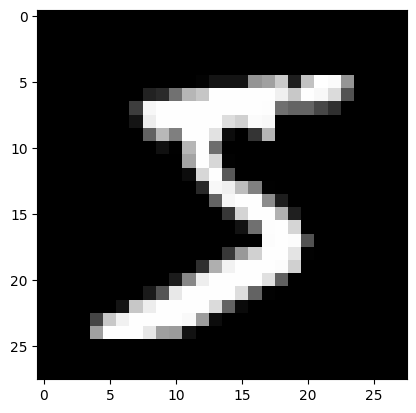

In [3]:
sample_data = datasets.MNIST("./datasets/", 
                             download=True, 
                             train=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(), 
                            ]))
plt.imshow(np.transpose(sample_data[0][0].numpy(), (1,2,0)), 
           cmap='Greys_r') # [channel, height, width] -> [height, width, channel]

In [4]:
batch_size = 128
pin_memory = True
num_workers = 0
shuffle = True
device = torch.device("cuda")
epochs = 1
num_diffusion_timestep = 1000


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32), 
                      interpolation=transforms.InterpolationMode.BICUBIC, 
                      antialias=True),#插值的方法
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
])

train_dataset = datasets.MNIST("./datasets/", 
                         download=True, 
                         train=True,
                         transform=transform)

test_data = datasets.MNIST('./datasets/', 
                           train=False, 
                           download=True, 
                           transform=transform)
# dataset[0]
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          pin_memory=pin_memory, 
                          num_workers=num_workers,
                          shuffle=shuffle,
                          drop_last=True)

test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         pin_memory=pin_memory,
                         num_workers=num_workers,
                         shuffle=False,
                         drop_last=True)


这里， 我们对图像进行加噪声
初始化超参数
$\beta_t$                       
$\alpha_t = 1-\beta_t$      
$\sqrt{\alpha_t} = \sqrt{1-\beta_t}$                                                
$\overline{\alpha}=\prod_{t=1}^{T}\alpha_t$     
$\sqrt{1-\overline{\alpha}}$        

In [6]:
class diffusion_setting:
    def __init__(self, num_diffusion_timestep) -> None:
        self.timestep = num_diffusion_timestep
        self.initialize()
    
    def initialize(self):
        # calculate all the settings for every timesteps, store in a tensor matrix
        # BETAs & ALPHAs required at different places in the Algorithm.
        self.beta = self.get_beta()
        self.alpha = 1-self.beta
        self.one_by_sqrt_alpha_s = 1. / torch.sqrt(self.alpha)
        self.sqrt_beta_s = torch.sqrt(self.beta)  # the var for denoising
        
        # a single calculated cumulative values
        self.alpha_cumulative = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_cumulative = torch.sqrt(self.alpha_cumulative)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)
        
    
    def get_beta(self):
        ## linear schedule, following original ddpm paper
        scale = 1000/ self.timestep
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        return torch.linspace(beta_start, 
                              beta_end, 
                              self.timestep,
                              dtype=torch.float32, 
                              device=device)

  
    

$$x_t=\sqrt{\overline{\alpha_t}} x_0+\sqrt{1-\overline{\alpha_t}} z_t$$

In [7]:
def forward_diffusion(DS, 
                      X_0, 
                      batch_timestep):
    """ 
    前向加噪声过程
    """
    # sample a batch of Noise ~ N(0,1)
    z_t = torch.randn_like(X_0) # [bz, c, w, h]
    
    # Images scaled to X_t_batch/sqrt(alpha_t)
    batch_sqrt_alpha_cumulative = torch.gather(input=DS.sqrt_alpha_cumulative, 
                                               index=batch_timestep, 
                                               dim=0) # 维度 [bz]
    mean = batch_sqrt_alpha_cumulative.reshape(-1, 1, 1, 1) * X_0
    batch_sqrt_one_minus_alpha_cumulative = torch.gather(input=DS.sqrt_one_minus_alpha_cumulative, 
                                                         index=batch_timestep,
                                                         dim=0).reshape(-1, 1, 1, 1)
    return mean + batch_sqrt_one_minus_alpha_cumulative*z_t, z_t
    
    

## 定义模型


### 定义正弦余弦位置信息
$$\begin{aligned}
& P E_{(\mathrm{pos}, 2 i)}=\sin \left(\operatorname{pos} / 10000^{2 i / d_{\text {model }}}\right) \\
& P E_{(p o s, 2 i+1)}=\cos \left(\operatorname{pos} / 10000^{2 i / d_{\text {model }}}\right)
\end{aligned}$$

In [8]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512) -> None:
        super().__init__()
        
        half_dim =  time_emb_dims//2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)

        ts = torch.arange(total_time_steps, dtype=torch.float32)

        emb = torch.unsqueeze(ts, dim=-1) * torch.unsqueeze(emb, dim=0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        self.time_block = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(in_features=time_emb_dims, out_features=time_emb_dims_exp),
            nn.SiLU(),
            nn.Linear(in_features=time_emb_dims_exp, out_features=time_emb_dims_exp)
        )
    def forward(self, time):
        return self.time_block(time)
 

class DownSample(nn.Module):
    def __init__(self, channels) -> None:
        super().__init__() 
        self.downsample = nn.Conv2d(in_channels=channels, 
                                    out_channels=channels, 
                                    kernel_size=3, 
                                    stride=2, 
                                    padding=1)  
    def forward(self, x, *args):
        return self.downsample(x)
    
class UpSample(nn.Module):
    def __init__(self, in_channels) -> None:
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=in_channels, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1))
        
    def forward(self, x, *args):
        return self.upsample(x)

class AttentionBlock(nn.Module):
    def __init__(self, channels=64) -> None:
        super().__init__()
        self.channels = channels
        self.group_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mhsa = nn.MultiheadAttention(embed_dim=self.channels, num_heads=4, batch_first=True)
        
    def forward(self, x):
        B, _, H, W = x.shape
        h = self.group_norm(x)
        h = h.reshape(B, self.channels, H*W).swapaxes(1, 2) # [B, C, H, W] --> [B, C, H * W] --> [B, H*W, C]
        h, _ = self.mhsa(h, h, h)
        h = h.swapaxes(2, 1).view(B, self.channels, H, W) # [B, C, H*W] --> [B, C, H, W]
        return x+h

  
class ResnetBlock(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 dropout_rate=0.1, 
                 time_emb_dims=512, 
                 apply_attention=False) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.act_fn = nn.SiLU()
        
        # Group 1
        self.normlize_1 = nn.GroupNorm(num_groups=8, 
                                       num_channels=self.in_channels)
        self.conv_1 = nn.Conv2d(in_channels=self.in_channels, 
                                out_channels=self.out_channels, 
                                kernel_size=3, 
                                stride=1, 
                                padding="same")
        
        # Group 2 time embedding
        self.dense_1 = nn.Linear(in_features=time_emb_dims, out_features=self.out_channels)
        
        # Group 3
        self.normlize_2 = nn.GroupNorm(num_groups=8, num_channels=self.out_channels)
        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.conv_2 = nn.Conv2d(in_channels=self.out_channels, 
                                out_channels=self.out_channels, 
                                kernel_size=3, 
                                stride=1, 
                                padding="same")
        
        if self.in_channels != self.out_channels:
            self.match_input = nn.Conv2d(in_channels=self.in_channels, 
                                         out_channels=self.out_channels, 
                                         kernel_size=1, stride=1)
        else:
            self.match_input = nn.Identity()
        
        if apply_attention:
            self.attention = AttentionBlock(channels=self.out_channels)
        else:
            self.attention = nn.Identity()  
    
    def forward(self, x, t):
        # group 1
        h = self.act_fn(self.normlize_1(x))
        h = self.conv_1(h)
        
        # group 2 
        # add in timestep embedding
        h += self.dense_1(self.act_fn(t))[:, :, None, None] #
        
        # group 3
        h = self.act_fn(self.normlize_2(h))
        h = self.dropout(h)
        h = self.conv_2(h)
        
        # Residual and attention
        h = h + self.match_input(x)
        h = self.attention(h) 
         
        return h
        
class Unet(nn.Module):
    def __init__(self, 
                 input_channels=3,
                 output_channels=3,
                 num_res_blocks=2,
                 base_channels=128,
                 base_channels_multiples=(1, 2, 4, 8),
                 apply_attention=(False, False, True, False),
                 dropout_rate=0.1,
                 time_multiple=4,
                 ) -> None:
        super().__init__()
        
        time_emb_dims_exp = base_channels * time_multiple # 32 * 4=128
        self.time_embeddings = SinusoidalPositionEmbeddings(time_emb_dims=base_channels,
                                                            time_emb_dims_exp=time_emb_dims_exp)
        
        self.first = nn.Conv2d(in_channels=input_channels, 
                               out_channels=base_channels,
                               kernel_size=3, stride=1, padding="same")
        
        num_resolutions = len(base_channels_multiples) 
        
        # Encoder part of The Unet. Dimension reduction
        self.encoder_blocks = nn.ModuleList()
        curr_channels = [base_channels]
        in_channels = base_channels
        
        for level in range(num_resolutions):
            out_channels = base_channels * base_channels_multiples[level]
            
            for _ in range(num_res_blocks):
                block = ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level]
                )
                self.encoder_blocks.append(block)
                
                in_channels = out_channels
                curr_channels.append(in_channels)
            
            if level != (num_resolutions-1):
                self.encoder_blocks.append(DownSample(channels=in_channels))
                curr_channels.append(in_channels)
        
        # Bottleneck in between
        self.bottleneck_block = nn.ModuleList(
            (
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels, 
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=True
                ),
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=False,
                )
            )
        ) 
        
        # Decoder part of the Unet. Dimension restoration with skip-connections. 
        self.decoder_blocks = nn.ModuleList()
        
        for level in reversed(range(num_resolutions)):
            
            out_channels = base_channels * base_channels_multiples[level]
            
            for _ in range(num_res_blocks+1):
                encoder_in_channels = curr_channels.pop()
                block = ResnetBlock(
                    in_channels=encoder_in_channels+in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level]
                )
                in_channels = out_channels
                self.decoder_blocks.append(block)
            
            if level !=0:
                self.decoder_blocks.append(UpSample(in_channels=in_channels))
        
        
        self.final = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=output_channels, kernel_size=3, stride=1, padding="same")
        )
                     
    def forward(self, x, t):
        time_emb = self.time_embeddings(t)
        
        h = self.first(x)
        outs = [h]
        
        for layer in self.encoder_blocks:
            h = layer(h, time_emb)
            outs.append(h)
        
        for layer in self.bottleneck_block:
            h = layer(h, time_emb)
            
        for layer in self.decoder_blocks:
            if isinstance(layer, ResnetBlock):
                out = outs.pop()
                h = torch.cat([h, out], dim=1)
            h = layer(h, time_emb)
            
        h = self.final(h)
        
        
        return h       
        
    

In [9]:
model = Unet(input_channels=1, 
             output_channels=1, 
             base_channels=64, 
             base_channels_multiples=(1, 2, 4, 8),
             apply_attention=(False, False, True, False),
             dropout_rate=0.1,
             time_multiple=2)
model = model.to(device)
# batch_timesteps = torch.arange(128)
# X_train = torch.randn((128, 1, 32, 32))
# model(X_train, batch_timesteps)

In [10]:
DS = diffusion_setting(num_diffusion_timestep=num_diffusion_timestep)   
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
loss_fn = nn.MSELoss()
epochs = 10

确定扩散过程任意时刻的采样值
- 公式：
  $q(x_t|x_0) = N(x_t; \sqrt{\bar{a_t}}x_0, \sqrt{1-\bar{a_t}}I)$

In [11]:
model.train()
for epoch in range(epochs):
    total_loss = 0.0
    with tqdm(total=len(train_loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch:{epoch}/{epochs}")
    
    for X_0_batch, _ in train_loader:
        X_0_batch = X_0_batch.to(device)
        # Assign a batch of timesteps to each X0 sample
        batch_timesteps = torch.randint(low=1, 
                                        high=num_diffusion_timestep, 
                                        size=(X_0_batch.shape[0],), 
                                        device=device)
        
        X_t_batch, Real_noise_batch = forward_diffusion(DS=DS, X_0=X_0_batch, batch_timestep=batch_timesteps)
        # the model are asked to predict the noise added in diffusing
        
        pred_noise = model(X_t_batch, batch_timesteps)
        loss = loss_fn(Real_noise_batch, pred_noise)
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        tq.set_postfix_str(s=f"Loss: {loss.item():.4f}")
        print(f"Loss: {loss.item():.4f}")
    tq.set_postfix_str(s=f"Epoch Loss: {total_loss/len(train_loader):.4f}") 
    print(f"Epoch Loss: {total_loss/len(train_loader):.4f}")   


Train :: Epoch:0/10:   0%|          | 0/469 [00:00<?, ?it/s]


Loss: 0.9631
Loss: 0.6060
Loss: 0.4160
Loss: 0.2870
Loss: 0.2865
Loss: 0.2225
Loss: 0.2206
Loss: 0.2105
Loss: 0.1761
Loss: 0.1709
Loss: 0.1695
Loss: 0.1703
Loss: 0.1652
Loss: 0.1288
Loss: 0.1447
Loss: 0.1578
Loss: 0.1415
Loss: 0.1338
Loss: 0.1393
Loss: 0.1382
Loss: 0.1435
Loss: 0.1563
Loss: 0.1377
Loss: 0.1143
Loss: 0.1133
Loss: 0.1226
Loss: 0.1327
Loss: 0.1232
Loss: 0.0986
Loss: 0.1382
Loss: 0.0940
Loss: 0.1255
Loss: 0.1303
Loss: 0.1105
Loss: 0.1254
Loss: 0.1054
Loss: 0.0987
Loss: 0.0920
Loss: 0.1086
Loss: 0.0951
Loss: 0.1173
Loss: 0.0886
Loss: 0.1000
Loss: 0.1095
Loss: 0.0930
Loss: 0.0964
Loss: 0.1010
Loss: 0.0880
Loss: 0.0981
Loss: 0.0938
Loss: 0.0828
Loss: 0.0859
Loss: 0.0945
Loss: 0.0900
Loss: 0.0670
Loss: 0.0882
Loss: 0.0898
Loss: 0.0868
Loss: 0.0758
Loss: 0.0712
Loss: 0.0695
Loss: 0.0795
Loss: 0.0684
Loss: 0.0681
Loss: 0.0869
Loss: 0.0808
Loss: 0.0826
Loss: 0.0643
Loss: 0.0706
Loss: 0.0906
Loss: 0.0853
Loss: 0.0654
Loss: 0.0610
Loss: 0.0746
Loss: 0.0854
Loss: 0.0711
Loss: 0.0611

RuntimeError: The size of tensor a (128) must match the size of tensor b (96) at non-singleton dimension 0

## 逆扩散过程（Sampling）
$\mathbf{x}_{t-1}=\frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)\right)+\sigma_t \mathbf{z}$

$\sigma_t = \frac{1-\bar{\alpha_{t-1}}}{1-\bar{\alpha}_t} * {beta_t}$

In [16]:
@torch.inference_mode()
def denoising_diffusion(model, DS:diffusion_setting, X_t, timestep, start_at_T):
    eps = torch.randn_like(X_t)  if not start_at_T else torch.zeros_like(X_t)
    predicted_noise = model(X_t, timestep)
    
    beta_t = torch.gather(input=DS.beta, index=timestep, dim=0).reshape(-1, 1, 1, 1)
    one_by_sqrt_alpha_t = torch.gather(input=DS.one_by_sqrt_alpha_s, index=timestep, dim=0).reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_cumulative_t = torch.gather(input=DS.sqrt_one_minus_alpha_cumulative, index=timestep, dim=0).reshape(-1, 1, 1, 1)
    
    mean = one_by_sqrt_alpha_t * (X_t - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
    # todo here, the authors take the sqrt(beta_t) from diffusing process
    # instead of mathematical results of [1-alpha_cumulative(t-1)] * beta_t / [1-alpha_cumulative(t)]
    var = torch.gather(input=DS.sqrt_beta_s, index=timestep, dim=0).reshape(-1, 1, 1, 1)
    X_t_minus_1 = mean + var * eps
    return X_t_minus_1
    
    

In [17]:
model.eval()
num_images = 5
img_shape = (1, 32, 32)
x_T = torch.randn((num_images, *img_shape), device=device)  # [num_images, C, H, W]
x_t = x_T  # the first X_t
for time_step in tqdm(iterable=reversed(range(1, num_diffusion_timestep)), 
                      total=num_diffusion_timestep-1, dynamic_ncols=False,
                      desc="Sampling :: ", position=0):
    time_step_batch = torch.ones(num_images, 
                                 dtype=torch.long, 
                                 device=device) * time_step
    x_t = denoising_diffusion(model, 
                              DS, 
                              x_t, 
                              timestep=time_step_batch, 
                              start_at_T=True if time_step == 1 else False)
    print(x_t.shape)
    
    
    
    
    


Sampling ::   0%|          | 0/999 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.92 GiB total capacity; 7.70 GiB already allocated; 28.12 MiB free; 7.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF